# Fixed Spot Histogram Evaluation

We are now looking into the `FixedSpotHistogramEvaluation` which inherits `FixedSpotDetectionEvaluation`

In [5]:
%load_ext autoreload
%autoreload 2
    
import sys
import numpy as np
from pathlib import Path

project_root = Path().absolute().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from matplotlib import pyplot as plt

%matplotlib ipympl

from pyeval import GzipPickleDataset, FixedSpotHistogramEvaluation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
dataset = GzipPickleDataset("/tmp/AA_clock_spect_0G")
len(dataset)

767

In [18]:
evaluation = FixedSpotHistogramEvaluation(spot_counts=16, spot_radius=3, spot_sums_bins=50)
evaluation.evaluate(dataset)

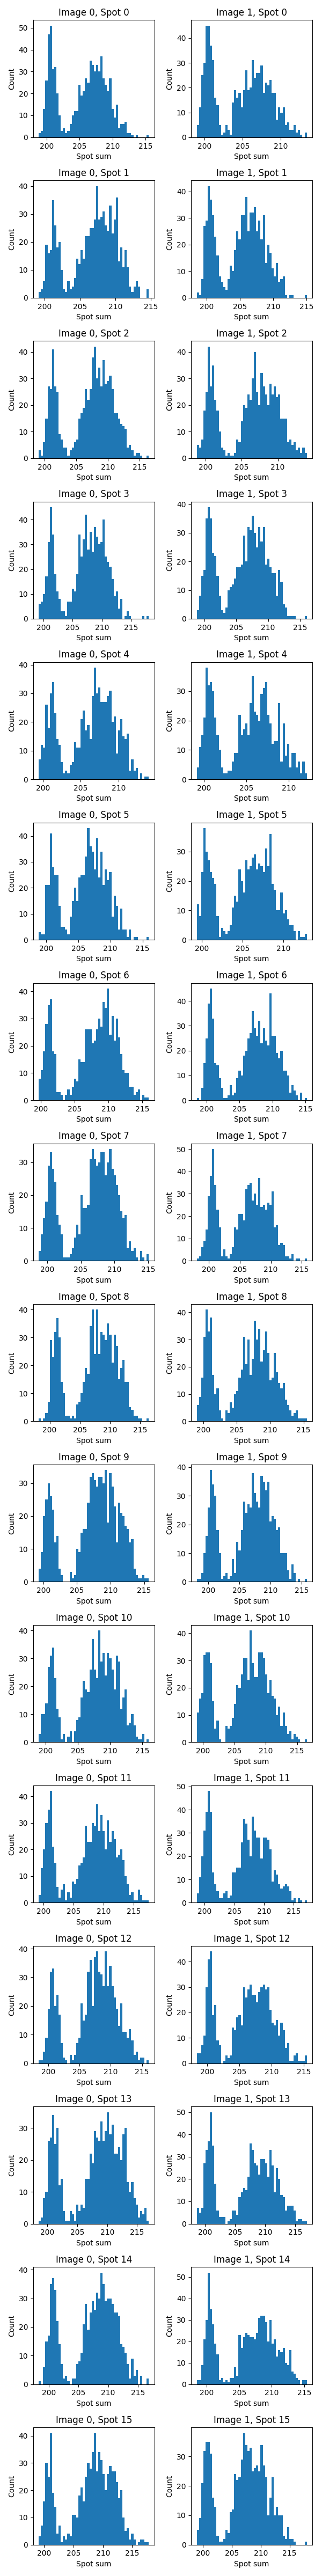

In [19]:
evaluation.plot_spot_sums_histograms()

In [20]:
evaluation.spot_sums_counts.shape

(2, 16, 50)

In [25]:
i, j = 0, 0

bin_center = evaluation.spot_sums_bincenters[i, j]
bin_width = evaluation.spot_sums_binwidths[i, j]
counts = evaluation.spot_sums_counts[i, j]

In [26]:
bin_center

array([198.96265306, 199.29612245, 199.62959184, 199.96306122,
       200.29653061, 200.63      , 200.96346939, 201.29693878,
       201.63040816, 201.96387755, 202.29734694, 202.63081633,
       202.96428571, 203.2977551 , 203.63122449, 203.96469388,
       204.29816327, 204.63163265, 204.96510204, 205.29857143,
       205.63204082, 205.9655102 , 206.29897959, 206.63244898,
       206.96591837, 207.29938776, 207.63285714, 207.96632653,
       208.29979592, 208.63326531, 208.96673469, 209.30020408,
       209.63367347, 209.96714286, 210.30061224, 210.63408163,
       210.96755102, 211.30102041, 211.6344898 , 211.96795918,
       212.30142857, 212.63489796, 212.96836735, 213.30183673,
       213.63530612, 213.96877551, 214.3022449 , 214.63571429,
       214.96918367, 215.30265306])

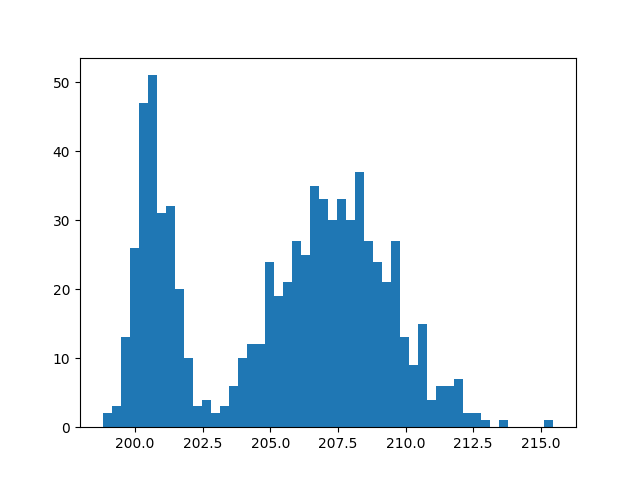

In [27]:
plt.figure()
plt.bar(bin_center, counts, width=bin_width)
plt.show()

In [57]:
def model(x, amp1, amp2, mean1, mean2, var1, var2, offset):
    return amp1 * np.exp(- (x-mean1)**2 / (2*var1)) + amp2 * np.exp(- (x-mean2)**2 / (2*var2)) + offset

In [73]:
import numpy as np
from lmfit import Model, Parameters


def gaussian_mixture(x, **params):
    n = sum(1 for key in params.keys() if key.startswith("amp"))

    y = np.zeros_like(x)
    for i in range(n):
        amp = params[f"amp{i}"]
        mean = params[f"mean{i}"]
        width = params[f"width{i}"]
        y += amp * np.exp(-((x - mean) ** 2) / width**2)

    return y + params["offset"]


class GaussianMixture:
    def __init__(self, n: int):
        self.n = n
        self.model = Model(gaussian_mixture)
        self.params = Parameters()
        self.result = None

    def fit(self, x, y):
        for i in range(self.n):
            self.params.add(f"amp{i}", value=y.max(), min=y.min())
            self.params.add(
                f"mean{i}",
                value=x.min() + (x.max() - x.min()) * i / (self.n - 1),
                min=x.min(),
                max=x.max(),
            )
            self.params.add(f"width{i}", value=x.std(), min=0.01)

        self.params.add("offset", value=y.min())

        self.result = self.model.fit(y, self.params, x=x)

    def predict(self, x):
        if self.result is None:
            raise ValueError("Model has not been fitted yet")
        return self.result.eval(x=x)


In [74]:
gm = GaussianMixture(2)
gm.fit(bin_center, counts)

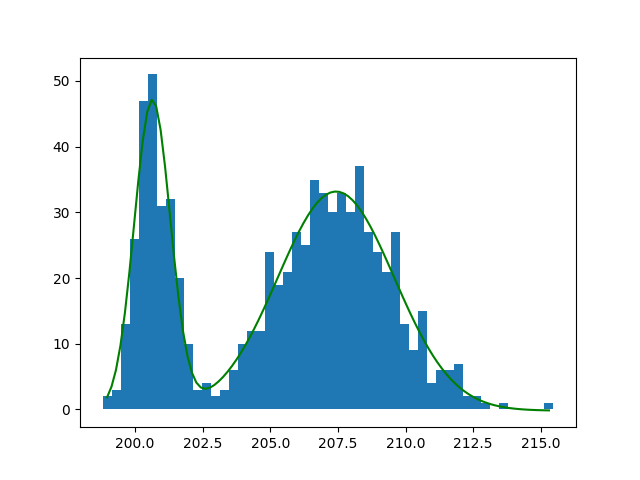

In [75]:
x = np.linspace(bin_center[0], bin_center[-1], 100)
y = gm.predict(x)

plt.figure()
plt.bar(bin_center, counts, width=bin_width)
plt.plot(x, y, color='green')
plt.show()

In [56]:
popt

array([1.89422483e+01, 1.58170271e-10, 2.00000000e+02, 2.05000000e+02,
       3.62778337e-21])